# Introduction

Installation for any of the dependencies are skipped as they can be found in their respective documentations

The material in this document are a summation of the official PyTorch documentation, several tutorial notebooks and my own experience. Material for further study can be found at the last cell of the notebook.

Some of the cells are there for reference use and may be skipped during the lecture.

This notebook goes over the following topics:
* Tensors 
* Data I/O
* Model Pipeline
* Training
* Model Evaluation
* Saving Models

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Tensors

In PyTorch, Model I/O and its parameters are encoded with tensors. A tensor can be seen as a data structure similar to arrays or matrices, they're actually compatible with lots of existing types (such as NumPy ndarray) but they're optimized for certain operations in PyTorch.

In [2]:
# there're several ways of initializing tensors
# converting from a regular multi dimensional list
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

# converting from a numpy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# we can also convert a tensor back to numpy
t_np = x_np.numpy()

# common functions to create tensors, similiar to numpy
shape = (2,3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

# we can also create arrays like other tensors, in terms of shape and datatype
rand_like_tensor = torch.rand_like(rand_tensor)

print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")
print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Another Random Tensor: \n {rand_like_tensor} \n")

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])
Random Tensor: 
 tensor([[0.5791, 0.8736, 0.3204],
        [0.1171, 0.1185, 0.6914]]) 

Another Random Tensor: 
 tensor([[0.1946, 0.1432, 0.7279],
        [0.5786, 0.8747, 0.7659]]) 



In [3]:
# ideally, we'd want to store our tensors and compute our operations on a gpu as they are way more effective
# the following code can be tested on colab with a gpu runtime
# we could also create the tensor directly on the gpu as well
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [15]:
# commonly used operations
# matrix multiplication, each of the y values are the same
tensor = torch.rand([3,3])
y1 = tensor @ tensor.T 
y2 = tensor.matmul(tensor.T)
y3 = torch.zeros_like(y1) # zeros array in the shape of multiplication
print(torch.matmul(tensor, tensor.T, out=y3))

# element wise multiplication, each of the z values are the same
z2 = tensor.mul(tensor)
z3 = torch.zeros_like(tensor)
print(torch.mul(tensor, tensor, out=z3))

tensor([[0.9367, 0.4597, 1.1347],
        [0.4597, 1.1758, 1.0923],
        [1.1347, 1.0923, 1.6811]])
tensor([[0.0168, 0.0837, 0.8362],
        [0.7390, 0.4045, 0.0323],
        [0.3206, 0.4701, 0.8905]])


# Data I/O

## Pre-Loaded Datasets

In [16]:
# there're many pre-loaded datasets available in pytorch itself
# these datasets are commonly used as benchmarks or for demo purposes so it's a good idea to try them out
from torchvision.transforms import ToTensor
from torchvision import datasets

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

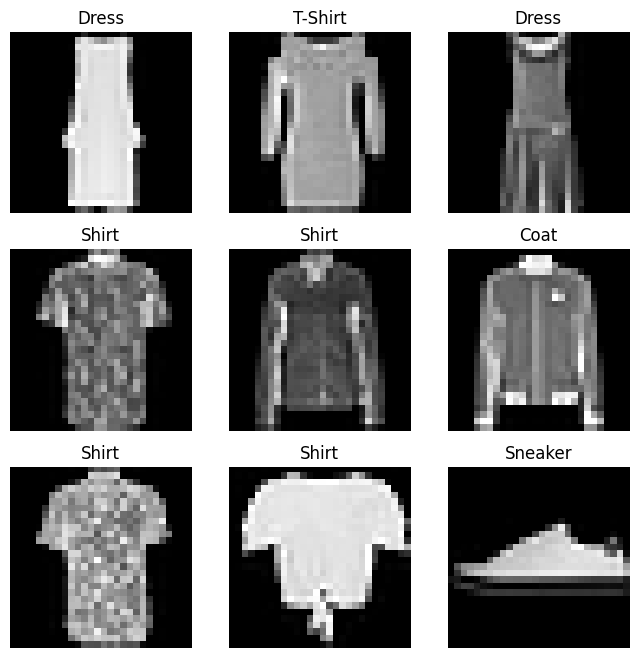

In [17]:
# this plots 9 random samples from the training set
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Custom Datasets

There are a few different ways to create a custom dataset in PyTorch, this'll go over the most common ones.


In [18]:
# a custom dataset class must implement key magic methods of the parent class
from torch.utils.data import DataLoader, Dataset, TensorDataset
class EarthquakeData(Dataset):
    def __init__(self, data_file, normalize=False):
        self.data = pd.read_csv(data_file, sep='\t', header=None)
        if normalize:
            self.mean = np.mean(self.data, axis=0)
            self.std = np.std(self.data, axis=0)
            self.data = (self.data - self.mean) / (self.std + 1e-7) 
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # get the row for the given index
        row = self.data.iloc[idx].values.astype('float32')
        # the magnitude value is the last array member
        # after getting the magnitude, we cut it out from the array
        return row[105:-1], row[-1]

In [34]:
train_path = 'DATA_split/DATA_4sn_trn.txt'
test_path = 'DATA_split/DATA_4sn_val.txt'

# custom class instances
training_data = EarthquakeData(train_path, normalize=True)
test_data = EarthquakeData(test_path, normalize=True)

# split the data into batches, each batch contains 64 signals in this case
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# alternative way:
# if we already have access to the data arrays we could also use the following
train_txt = pd.read_csv('DATA_split/DATA_4sn_trn.txt', sep='\t', header=None)
X_train = torch.tensor(train_txt.iloc[:, :-1].values, dtype=torch.float32)
y_train = torch.tensor(train_txt.iloc[:, -1].values, dtype=torch.float32)
alternative_dataset = TensorDataset(X_train, y_train)
alternative_loader = DataLoader(alternative_dataset, batch_size=64, shuffle=False)

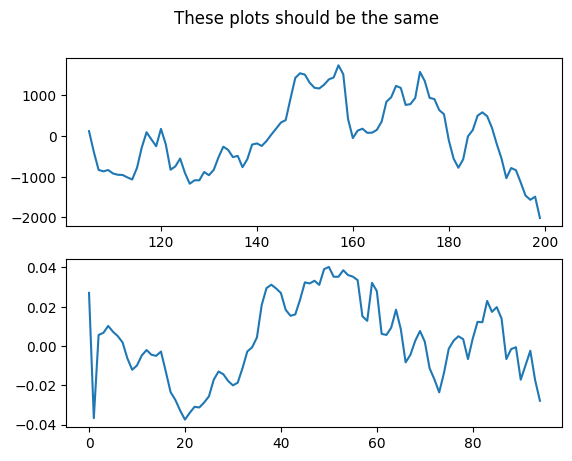

In [35]:
# nothing magical happens when we use the dataloader, it just organizes the data in a useful way 
# but it offers many customizations to this organization
# if we were to load the data regularly and organize it ourselves it'd be the same thing basically
batch_sample, sample_label = next(iter(train_dataloader))
fig, axs = plt.subplots(2)
fig.suptitle('These plots should be the same')
axs[0].plot(train_txt.iloc[0][105:-1]) # first sample of the whole training set
axs[1].plot(batch_sample[0]) # first sample of the first batch

# Building Models

## Linear Regression

In [36]:
# there's a faster way to create models, which we'll cover later.
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        # one linear layer in the form of y = x*A.T+b
        self.linear = nn.Linear(input_dim, 1)
    
    # this defines what the model does in a forward pass
    def forward(self, x):
        # pass the input to the linear layer
        return self.linear(x)

train_dim = next(iter(training_data))[0].shape[0]

## MLP

In [37]:
import torch.nn.functional as F
some_dim = 95
class MLP(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Linear(some_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1))

# we could also define the same model like this
MLP = nn.Sequential(
   nn.Linear(some_dim, 64),
   nn.ReLU(),
   nn.Linear(64, 32),
   nn.ReLU(),
   nn.Linear(32, 1))

class MLP(torch.nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x)) # pass x to the first fully connected layer to a relu
        x = F.relu(self.fc2(x)) # same for the second layer
        x = self.fc3(x) # now pass the x to the last fc and return it
        return x


# Training Models

In [38]:
def train(model, train_dataloader, optimizer, criterion, n_epochs = 20):
    train_losses = []
    val_losses = []
    # usually, the optimal parameters are not reached in one pass
    # 
    for epoch in range(n_epochs):
        model.train() # switch the model to train mode
        # this is done so that certain layers that behave differently in different modes behave correctly
        running_loss = 0.0
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            preds = model(X_batch) # get model predictions
            loss = criterion(preds.squeeze(), y_batch) # results of the loss function
            loss.backward() # calculate the gradients
            optimizer.step() # take a optimizer step based on the current gradient
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_dataloader)
        print(f'Epoch [{epoch + 1}/{n_epochs}], '
            f'Train Loss: {train_loss:.4f}')

# Evaluating Models

In [39]:
def evaluate(model, test_dataloader, criterion):
    model.eval() # change model mode to evaluation
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            total_loss += loss.item()
    average_loss = total_loss / len(test_dataloader)
    print(f'Test Loss: {average_loss:.4f}')

## Processing

In [53]:
# let's start training the linear regression model
lr = LinearRegression(input_dim=train_dim)
criterion = nn.MSELoss() # most of the projects used mse as the loss functions, so we'll go with that
lr_optimizer = torch.optim.SGD(lr.parameters(), lr=1e-3) # fixed learning rate for now
train(model=lr, train_dataloader=train_dataloader, optimizer=lr_optimizer, criterion=criterion, n_epochs=50)

Epoch [1/50], Train Loss: 1.2219
Epoch [2/50], Train Loss: 1.0965
Epoch [3/50], Train Loss: 1.0358
Epoch [4/50], Train Loss: 1.0255
Epoch [5/50], Train Loss: 1.0176
Epoch [6/50], Train Loss: 1.0136
Epoch [7/50], Train Loss: 1.0106
Epoch [8/50], Train Loss: 1.0085
Epoch [9/50], Train Loss: 1.0069
Epoch [10/50], Train Loss: 1.0055
Epoch [11/50], Train Loss: 1.0044
Epoch [12/50], Train Loss: 1.0035
Epoch [13/50], Train Loss: 1.0027
Epoch [14/50], Train Loss: 1.0020
Epoch [15/50], Train Loss: 1.0014
Epoch [16/50], Train Loss: 1.0009
Epoch [17/50], Train Loss: 1.0004
Epoch [18/50], Train Loss: 1.0000
Epoch [19/50], Train Loss: 0.9996
Epoch [20/50], Train Loss: 0.9993
Epoch [21/50], Train Loss: 0.9989
Epoch [22/50], Train Loss: 0.9987
Epoch [23/50], Train Loss: 0.9984
Epoch [24/50], Train Loss: 0.9982
Epoch [25/50], Train Loss: 0.9979
Epoch [26/50], Train Loss: 0.9977
Epoch [27/50], Train Loss: 0.9975
Epoch [28/50], Train Loss: 0.9974
Epoch [29/50], Train Loss: 0.9972
Epoch [30/50], Train Lo

In [41]:
evaluate(lr, test_dataloader=test_dataloader, criterion=criterion)

Test Loss: 1.0095


In [43]:
# mlp
mlp = MLP(input_dim=train_dim)
criterion = nn.MSELoss() # most of the projects used mse as the loss functions, so we'll go with that
mlp_optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-3) # fixed learning rate for now
train(model=mlp, train_dataloader=train_dataloader, optimizer=mlp_optimizer, criterion=criterion, n_epochs=100)

Epoch [1/100], Train Loss: 1.0096
Epoch [2/100], Train Loss: 1.0035
Epoch [3/100], Train Loss: 0.9989
Epoch [4/100], Train Loss: 0.9953
Epoch [5/100], Train Loss: 0.9923
Epoch [6/100], Train Loss: 0.9898
Epoch [7/100], Train Loss: 0.9876
Epoch [8/100], Train Loss: 0.9856
Epoch [9/100], Train Loss: 0.9837
Epoch [10/100], Train Loss: 0.9820
Epoch [11/100], Train Loss: 0.9804
Epoch [12/100], Train Loss: 0.9789
Epoch [13/100], Train Loss: 0.9775
Epoch [14/100], Train Loss: 0.9762
Epoch [15/100], Train Loss: 0.9749
Epoch [16/100], Train Loss: 0.9736
Epoch [17/100], Train Loss: 0.9725
Epoch [18/100], Train Loss: 0.9713
Epoch [19/100], Train Loss: 0.9702
Epoch [20/100], Train Loss: 0.9691
Epoch [21/100], Train Loss: 0.9681
Epoch [22/100], Train Loss: 0.9671
Epoch [23/100], Train Loss: 0.9661
Epoch [24/100], Train Loss: 0.9652
Epoch [25/100], Train Loss: 0.9642
Epoch [26/100], Train Loss: 0.9633
Epoch [27/100], Train Loss: 0.9625
Epoch [28/100], Train Loss: 0.9616
Epoch [29/100], Train Loss: 0

In [44]:
evaluate(mlp, test_dataloader=test_dataloader, criterion=criterion)

Test Loss: 0.9988


# Saving Models

In [47]:
# learnable parameters of models and optimizers are kept in a state dict, which can be saved easily
print("MLP's state_dict:")
for param_tensor in mlp.state_dict():
    print(param_tensor, "\t", mlp.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in mlp_optimizer.state_dict():
    print(var_name, "\t", mlp_optimizer.state_dict()[var_name])

MLP's state_dict:
fc1.weight 	 torch.Size([64, 95])
fc1.bias 	 torch.Size([64])
fc2.weight 	 torch.Size([32, 64])
fc2.bias 	 torch.Size([32])
fc3.weight 	 torch.Size([1, 32])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}, 3: {'momentum_buffer': None}, 4: {'momentum_buffer': None}, 5: {'momentum_buffer': None}}
param_groups 	 [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5]}]


In [48]:
# now if save this parameters, we can load the model as long as we have the model instance
# this is a preferred way of saving models since the conditions are a easier to replicate on different devices
dict_path = './model_state.pt'
torch.save(mlp.state_dict(), dict_path)
loaded_dict_model = MLP(input_dim=train_dim)
loaded_dict_model.load_state_dict(torch.load(dict_path))
loaded_dict_model.eval()

MLP(
  (fc1): Linear(in_features=95, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
# you can can also save the model as a whole, which won't require the code for it
# but this is usually not preferred since there're lots of other variables that can fail (e.g dependencies)
model_path = './model.pt'
torch.save(mlp, model_path)
loaded_model = torch.load(model_path)
loaded_model.eval()

MLP(
  (fc1): Linear(in_features=95, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

# Additional Resources

* PyTorch Basics https://pytorch.org/tutorials/beginner/basics/intro.html
* Custom Dataset
https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f
* Forward Pass and Backprop https://towardsdatascience.com/neural-networks-forward-pass-and-backpropagation-be3b75a1cfcc
* Optimization https://martin-thoma.com/optimization-basics/
* I've skipped the SVM model as implementing it in PyTorch is rather impractical, but if you're curious on how it can be done you can check out https://bytepawn.com/svm-with-pytorch.html
* Learning Rate Scheduler https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/
* More Save/Load Functionality https://pytorch.org/tutorials/beginner/saving_loading_models.html
* More PyTorch Tutorials https://github.com/yunjey/pytorch-tutorial?tab=readme-ov-file